# EDA

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import matplotlib.pyplot as plt


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.4f}'.format)

In [3]:
df = pd.read_csv('university_model.csv')

In [4]:
df.head()

,degree_id,churn_target,is_remote,is_bachelor,is_female,active_semesters_first,is_state_funded_mean,age_at_start,is_fall_start,has_gap,is_state_funded_first,financial_status_changed,is_from_budapest,activity_ratio,grade_trajectory,started_strong,started_weak,credits_per_semester,credit_efficiency,cumulative_stability,performance_gap,efficiency_score,weighted_avg,improvement_rate
0,1_ETNEMBSC_Aktív_7.0,0,0,1,1,7.0000,1.0000,18.8000,1,0,1,0,1,1.0000,1.0600,1,0,29.4286,1.0000,0.6500,-0.4100,4.2900,4.3820,0.1514
1,2_ETNEMBSC_Diplomát szerzett_7.0,0,0,1,1,7.0000,0.8571,18.6000,1,0,0,1,0,1.0000,1.1200,0,0,27.8571,0.9701,0.7900,-0.3300,3.5604,3.6640,0.1600
2,3_3MLKERT_Törölt_6.0,1,1,0,0,6.0000,0.4000,25.4000,1,1,0,0,0,0.6000,-3.6000,1,0,16.5000,0.5380,0.1000,3.7000,1.9908,1.0800,-0.6000
3,4_7BNKOMM_Aktív_1.0,0,0,1,0,1.0000,0.0000,19.1000,1,0,0,0,0,1.0000,0.0000,0,1,24.0000,0.7742,0.0000,0.0000,0.0000,0.0000,0.0000
4,5_2BNGINFB_Aktív_1.0,0,0,1,0,1.0000,1.0000,21.3000,1,0,1,0,1,1.0000,0.0000,0,1,63.0000,0.7975,0.0000,0.0000,0.0000,0.0000,0.0000


In [5]:
degree_ids = df['degree_id'].copy()
X = df.drop(['churn_target','degree_id'], axis=1)
y = df['churn_target']
print(f"class distribution: {y.value_counts().to_dict()}")

class distribution: {0: 11884, 1: 2699}


In [6]:
X_temp, X_test, y_temp, y_test, degree_temp, degree_test = train_test_split(X, y, degree_ids, test_size=0.1, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp) 

In [7]:
print(f"training: {X_train.shape[0]:,} | validation: {X_val.shape[0]:,} | test: {X_test.shape[0]:,}")
print(f"split ratio: {X_train.shape[0]/len(X):.0%}/{X_val.shape[0]/len(X):.0%}/{X_test.shape[0]/len(X):.0%}")

training: 10,499 | validation: 2,625 | test: 1,459
split ratio: 72%/18%/10%


In [8]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
for cls, weight in class_weight_dict.items():
    print(f"class {cls}: {weight:.4f}")

class 0: 0.6135
class 1: 2.7017


In [9]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(f"After SMOTE: {pd.Series(y_train_smote).value_counts().to_dict()}")

After SMOTE: {0: 8556, 1: 8556}


In [10]:
def evaluate_model(model, X_train, y_train, X_val, y_val, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    
    auc = roc_auc_score(y_val, y_pred_proba)
    
    print(f"\n{name}:")
    print(f"validation AUC: {auc:.3f}")
    print(classification_report(y_val, y_pred, target_names=['most likely finish', 'churned']))
    
    return model, auc, y_pred_proba

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
# import lightgbm as lgb



In [12]:
models = {}

In [13]:
lr_weighted = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
models['LR_SMOTE'], auc_lr_smote, pred_lr_smote = evaluate_model(lr_weighted, X_train_smote, y_train_smote, X_val, y_val, "Logistic Regression SMOTE")
models['LR'], auc_lr, pred_lr = evaluate_model(lr_weighted, X_train, y_train, X_val, y_val, "Logistic Regression")


Logistic Regression SMOTE:
validation AUC: 0.957
                    precision    recall  f1-score   support

most likely finish       0.96      0.94      0.95      2139
           churned       0.74      0.83      0.79       486

          accuracy                           0.92      2625
         macro avg       0.85      0.88      0.87      2625
      weighted avg       0.92      0.92      0.92      2625


Logistic Regression:
validation AUC: 0.966
                    precision    recall  f1-score   support

most likely finish       0.97      0.93      0.95      2139
           churned       0.74      0.89      0.81       486

          accuracy                           0.92      2625
         macro avg       0.85      0.91      0.88      2625
      weighted avg       0.93      0.92      0.92      2625



In [14]:
rf_weighted = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)
models['RF_SMOTE'], auc_rf_smote, pred_rf_smote = evaluate_model(rf_weighted, X_train_smote, y_train_smote, X_val, y_val, "Random Forest SMOTE")
models['RF'], auc_rf, pred_rf = evaluate_model(rf_weighted, X_train, y_train, X_val, y_val, "Random Forest")



Random Forest SMOTE:
validation AUC: 0.981
                    precision    recall  f1-score   support

most likely finish       0.98      0.95      0.96      2139
           churned       0.81      0.90      0.85       486

          accuracy                           0.94      2625
         macro avg       0.89      0.93      0.91      2625
      weighted avg       0.95      0.94      0.94      2625


Random Forest:
validation AUC: 0.982
                    precision    recall  f1-score   support

most likely finish       0.96      0.97      0.96      2139
           churned       0.86      0.83      0.84       486

          accuracy                           0.94      2625
         macro avg       0.91      0.90      0.90      2625
      weighted avg       0.94      0.94      0.94      2625



In [15]:
gb_smote = GradientBoostingClassifier(random_state=42)
models['GB_SMOTE'], auc_gb_smote, pred_gb_smote = evaluate_model(gb_smote, X_train_smote, y_train_smote, X_val, y_val, "Gradient Boosting (SMOTE)")
models['GB'], auc_gb, pred_gb = evaluate_model(gb_smote, X_train, y_train, X_val, y_val, "Gradient Boosting")


Gradient Boosting (SMOTE):
validation AUC: 0.977
                    precision    recall  f1-score   support

most likely finish       0.98      0.94      0.96      2139
           churned       0.77      0.91      0.84       486

          accuracy                           0.93      2625
         macro avg       0.88      0.93      0.90      2625
      weighted avg       0.94      0.93      0.94      2625


Gradient Boosting:
validation AUC: 0.978
                    precision    recall  f1-score   support

most likely finish       0.97      0.96      0.96      2139
           churned       0.83      0.86      0.84       486

          accuracy                           0.94      2625
         macro avg       0.90      0.91      0.90      2625
      weighted avg       0.94      0.94      0.94      2625



In [16]:
xgb_weighted = XGBClassifier(scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),random_state=42, eval_metric='logloss')
models['XGB'], auc_xgb, pred_xgb = evaluate_model(xgb_weighted, X_train, y_train, X_val, y_val, "XGBoost")

models['XGB_smote'], auc_xgb_smote, pred_xgb_smote = evaluate_model(xgb_weighted, X_train_smote, y_train_smote, X_val, y_val, "XGBoost")


XGBoost:
validation AUC: 0.982
                    precision    recall  f1-score   support

most likely finish       0.98      0.95      0.96      2139
           churned       0.81      0.91      0.86       486

          accuracy                           0.94      2625
         macro avg       0.89      0.93      0.91      2625
      weighted avg       0.95      0.94      0.94      2625


XGBoost:
validation AUC: 0.980
                    precision    recall  f1-score   support

most likely finish       0.98      0.94      0.96      2139
           churned       0.78      0.90      0.83       486

          accuracy                           0.93      2625
         macro avg       0.88      0.92      0.90      2625
      weighted avg       0.94      0.93      0.94      2625



In [17]:
voting_clf = VotingClassifier(
    estimators=[('xgb', XGBClassifier(scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]), random_state=42, eval_metric='logloss')),
                ('rf', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))
    ],
    voting='soft'
)
models['Ensemble_Voting_SMOTE'], auc_voting_smote, pred_voting_smote = evaluate_model(voting_clf, X_train_smote, y_train_smote, X_val, y_val, "Ensemble (Voting) SMOTE")
models['Ensemble_Voting'], auc_voting, pred_voting = evaluate_model(voting_clf, X_train, y_train, X_val, y_val, "Ensemble (Voting)")


Ensemble (Voting) SMOTE:
validation AUC: 0.982
                    precision    recall  f1-score   support

most likely finish       0.98      0.94      0.96      2139
           churned       0.78      0.91      0.84       486

          accuracy                           0.94      2625
         macro avg       0.88      0.93      0.90      2625
      weighted avg       0.94      0.94      0.94      2625


Ensemble (Voting):
validation AUC: 0.984
                    precision    recall  f1-score   support

most likely finish       0.98      0.96      0.97      2139
           churned       0.83      0.91      0.87       486

          accuracy                           0.95      2625
         macro avg       0.90      0.93      0.92      2625
      weighted avg       0.95      0.95      0.95      2625



In [18]:
base_models = [('xgb', XGBClassifier(scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]), random_state=42, eval_metric='logloss')),
                ('rf', RandomForestClassifier(n_estimators=50, class_weight='balanced', random_state=42))]
stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(class_weight='balanced'),
    cv=3
)
models['Ensemble_Stacking'], auc_stacking, pred_stacking = evaluate_model(stacking_clf, X_train, y_train, X_val, y_val, "Ensemble (Stacking)")
models['Ensemble_Stacking_SMOTE'], auc_stacking_smote, pred_stacking_smote = evaluate_model(stacking_clf, X_train_smote, y_train_smote, X_val, y_val, "Ensemble (Stacking) SMOTE")


Ensemble (Stacking):
validation AUC: 0.983
                    precision    recall  f1-score   support

most likely finish       0.98      0.94      0.96      2139
           churned       0.78      0.94      0.85       486

          accuracy                           0.94      2625
         macro avg       0.88      0.94      0.91      2625
      weighted avg       0.95      0.94      0.94      2625


Ensemble (Stacking) SMOTE:
validation AUC: 0.981
                    precision    recall  f1-score   support

most likely finish       0.97      0.95      0.96      2139
           churned       0.81      0.88      0.85       486

          accuracy                           0.94      2625
         macro avg       0.89      0.92      0.90      2625
      weighted avg       0.94      0.94      0.94      2625



In [19]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_val_scaled = scaler.transform(X_val)

mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32), 
    activation='relu',
    solver='adam',
    alpha=0.01,
    batch_size=256,
    learning_rate='adaptive',
    max_iter=500,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1
)
mlp.fit(X_train_scaled, y_train_smote)
y_pred_mlp = mlp.predict(X_val_scaled)
y_pred_proba_mlp = mlp.predict_proba(X_val_scaled)[:, 1]
auc_mlp = roc_auc_score(y_val, y_pred_proba_mlp)

In [20]:
print(f"neural network:")
print(f"validation AUC: {auc_mlp:.3f}")
print(classification_report(y_val, y_pred_mlp, target_names=['most likely finish', 'churned']))

models['MLP_SMOTE'] = mlp

neural network:
validation AUC: 0.973
                    precision    recall  f1-score   support

most likely finish       0.98      0.94      0.96      2139
           churned       0.78      0.91      0.84       486

          accuracy                           0.94      2625
         macro avg       0.88      0.93      0.90      2625
      weighted avg       0.94      0.94      0.94      2625



In [21]:
aucs = {'LR': auc_lr, 'LR_SMOTE': auc_lr_smote, 'RF': auc_rf, 'RF_SMOTE': auc_rf_smote, 'GB_SMOTE': auc_gb_smote, 'GB': auc_gb, 'XGB': auc_xgb, 'XGB_SMOTE': auc_xgb_smote, 
    'MLP_SMOTE': auc_mlp, 'Ensemble_Voting': auc_voting, 'Ensemble_Voting_SMOTE': auc_voting_smote, 'Ensemble_Stacking': auc_stacking, 'Ensemble_Stacking_SMOTE': auc_stacking_smote}
best_model_name = max(aucs, key=aucs.get)
best_model = models[best_model_name]

print(f"BEST MODEL: {best_model_name} (AUC: {aucs[best_model_name]:.3f})")

BEST MODEL: Ensemble_Voting (AUC: 0.984)


In [22]:
if hasattr(best_model, 'estimators_'):
    # For ensemble models, get average importance from base estimators
    print("\nFeature Importance (averaged across ensemble):")
    importances = np.zeros(len(X.columns))
    count = 0
    
    for name, estimator in best_model.named_estimators_.items():
        if hasattr(estimator, 'feature_importances_'):
            importances += estimator.feature_importances_
            count += 1
    
    if count > 0:
        avg_importance = importances / count
        feature_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': avg_importance
        }).sort_values('importance', ascending=False)
        
        for i, row in feature_importance.iterrows():
            print(f"{row['feature']}: {row['importance']:.3f}")
    else:
        print("Feature importance not available for this ensemble model")



Feature Importance (averaged across ensemble):
credits_per_semester: 0.212
activity_ratio: 0.145
credit_efficiency: 0.132
active_semesters_first: 0.063
has_gap: 0.059
efficiency_score: 0.047
improvement_rate: 0.042
cumulative_stability: 0.041
weighted_avg: 0.037
performance_gap: 0.037
age_at_start: 0.028
is_fall_start: 0.025
started_weak: 0.024
grade_trajectory: 0.024
is_state_funded_mean: 0.019
is_bachelor: 0.016
is_remote: 0.011
started_strong: 0.011
is_from_budapest: 0.008
financial_status_changed: 0.007
is_female: 0.007
is_state_funded_first: 0.006


In [23]:
param_grid = {
    'xgb__n_estimators': [100, 150],
    'rf__n_estimators': [50, 100]
}
base_model = voting_clf
X_tune, y_tune = X_train, y_train


grid_search = GridSearchCV(base_model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_tune, y_tune)

GridSearchCV(cv=5,
             estimator=VotingClassifier(estimators=[('xgb',
                                                     XGBClassifier(base_score=None,
                                                                   booster=None,
                                                                   callbacks=None,
                                                                   colsample_bylevel=None,
                                                                   colsample_bynode=None,
                                                                   colsample_bytree=None,
                                                                   device=None,
                                                                   early_stopping_rounds=None,
                                                                   enable_categorical=False,
                                                                   eval_metric='logloss',
                                                                   feature_types=None,
                                                                   feature_weights=None,
                                                                   gamma=None,
                                                                   grow_policy=None,
                                                                   importa...
                                                                   max_depth=None,
                                                                   max_leaves=None,
                                                                   min_child_weight=None,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   multi_strategy=None,
                                                                   n_estimators=None,
                                                                   n_jobs=None,
                                                                   num_parallel_tree=None, ...)),
                                                    ('rf',
                                                     RandomForestClassifier(class_weight='balanced',
                                                                            random_state=42))],
                                        voting='soft'),
             n_jobs=-1,
             param_grid={'rf__n_estimators': [50, 100],
                         'xgb__n_estimators': [100, 150]},
             scoring='roc_auc')

In [24]:
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV AUC: {grid_search.best_score_:.3f}")

Best parameters: {'rf__n_estimators': 100, 'xgb__n_estimators': 100}
Best CV AUC: 0.974


In [25]:
final_model = grid_search.best_estimator_
y_final_pred = final_model.predict(X_test)
y_final_proba = final_model.predict_proba(X_test)[:, 1]
final_auc = roc_auc_score(y_test, y_final_proba)

print(f"FINAL MODEL PERFORMANCE")
print(f"Test AUC: {final_auc:.3f}")
print(classification_report(y_test, y_final_pred, target_names=['most likely finish', 'churned']))

FINAL MODEL PERFORMANCE
Test AUC: 0.974
                    precision    recall  f1-score   support

most likely finish       0.97      0.95      0.96      1189
           churned       0.79      0.88      0.83       270

          accuracy                           0.93      1459
         macro avg       0.88      0.91      0.89      1459
      weighted avg       0.94      0.93      0.93      1459



# ANALYSIS

In [26]:
cm = confusion_matrix(y_test, y_final_pred)
print(f"\nConfusion Matrix:")
print(f"True Negatives: {cm[0,0]},      False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]},       True Positives: {cm[1,1]}")

# Business metrics
precision_churn = cm[1,1] / (cm[1,1] + cm[0,1])
recall_churn = cm[1,1] / (cm[1,1] + cm[1,0])
print(f"\nBusiness Metrics:")
print(f"Churn Detection Rate (Recall): {recall_churn:.1%}")
print(f"Churn Prediction Accuracy (Precision): {precision_churn:.1%}")
print(f"Students correctly flagged as at-risk: {cm[1,1]}/{cm[1,1] + cm[1,0]}")


Confusion Matrix:
True Negatives: 1125,      False Positives: 64
False Negatives: 33,       True Positives: 237

Business Metrics:
Churn Detection Rate (Recall): 87.8%
Churn Prediction Accuracy (Precision): 78.7%
Students correctly flagged as at-risk: 237/270


In [27]:
risk_scores = final_model.predict_proba(X_test)[:, 1]
risk_bins = pd.qcut(risk_scores, q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

risk_analysis = pd.DataFrame({
    'actual_churn': y_test,
    'risk_score': risk_scores,
    'risk_bin': risk_bins
})

print("Churn rates by risk segment:")
for risk_level in ['Very Low', 'Low', 'Medium', 'High', 'Very High']:
    segment = risk_analysis[risk_analysis['risk_bin'] == risk_level]
    if len(segment) > 0:
        churn_rate = segment['actual_churn'].mean()
        print(f"{risk_level}: {churn_rate:.1%} ({len(segment)} students)")

# Feature importance for final model
if hasattr(final_model, 'feature_importances_'):
    final_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': final_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\n=== FEATURE IMPORTANCE (FINAL MODEL) ===")
    for i, row in final_importance.head(10).iterrows():
        print(f"{row['feature']}: {row['importance']:.3f}")

print(f"Model type: {type(final_model).__name__}")
print(f"Test AUC: {final_auc:.3f}")
print(f"Can identify {recall_churn:.1%} of at-risk students")

Churn rates by risk segment:
Very Low: 0.0% (292 students)
Low: 0.3% (292 students)
Medium: 0.3% (291 students)
High: 12.3% (292 students)
Very High: 79.5% (292 students)
Model type: VotingClassifier
Test AUC: 0.974
Can identify 87.8% of at-risk students


In [28]:
# predictions and probabilities for churn from predict_proba
y_pred_proba = final_model.predict_proba(X_test)[:, 1]
# print(y_pred_proba)
# comprehensive analysis DataFrame
results_df = pd.DataFrame({'degree_id': degree_test.values,'actual_churn': y_test, 'churn_probability': y_pred_proba,**{col: X_test[col].values for col in X.columns}})

# print(len(results_df))

# Create risk segments 
# --> cut the students into five equal sized buckets (in each bucket 1459/5 studednets placed) churn probability into five buckets
# results_df['risk_segment'] = pd.qcut(results_df['churn_probability'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
_, bins = pd.qcut(results_df['churn_probability'], q=5, retbins=True)

# Create labels based on probability ranges
threshold_labels = [
   f'{bins[0]:.2%}-{bins[1]:.2%}',
   f'{bins[1]:.2%}-{bins[2]:.2%}', 
   f'{bins[2]:.2%}-{bins[3]:.2%}',
   f'{bins[3]:.2%}-{bins[4]:.2%}',
   f'{bins[4]:.2%}-100%'
]

results_df['risk_segment'] = pd.qcut(results_df['churn_probability'], q=5, labels=threshold_labels)
# cut points
thresholds = pd.qcut(results_df['churn_probability'], q=5, retbins=True)[1]
print("bucket thresholds:")
for i, threshold in enumerate(thresholds):
    print(f"{i}: {threshold:.3f}")



bucket thresholds:
0: 0.000
1: 0.000
2: 0.002
3: 0.015
4: 0.537
5: 1.000


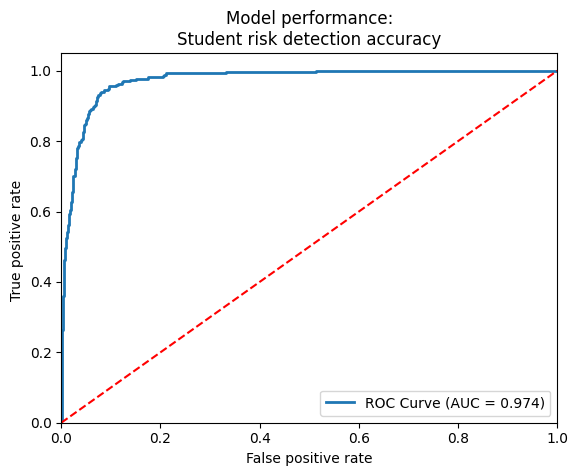

In [29]:
# ROC Curve with - Shows how well model distinguishes between churners and non-churners
# Curve closer to top-left corner == better model
# Diagonal line == random guessing (50% accuracy)

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# 0.5 = Random guessing 
# 1.0 = Perfect prediction
# MINE 0.951 = Excellent performance
plt.plot(fpr, tpr, lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate ')
plt.title('Model performance:\nStudent risk detection accuracy')
plt.legend(loc="lower right")


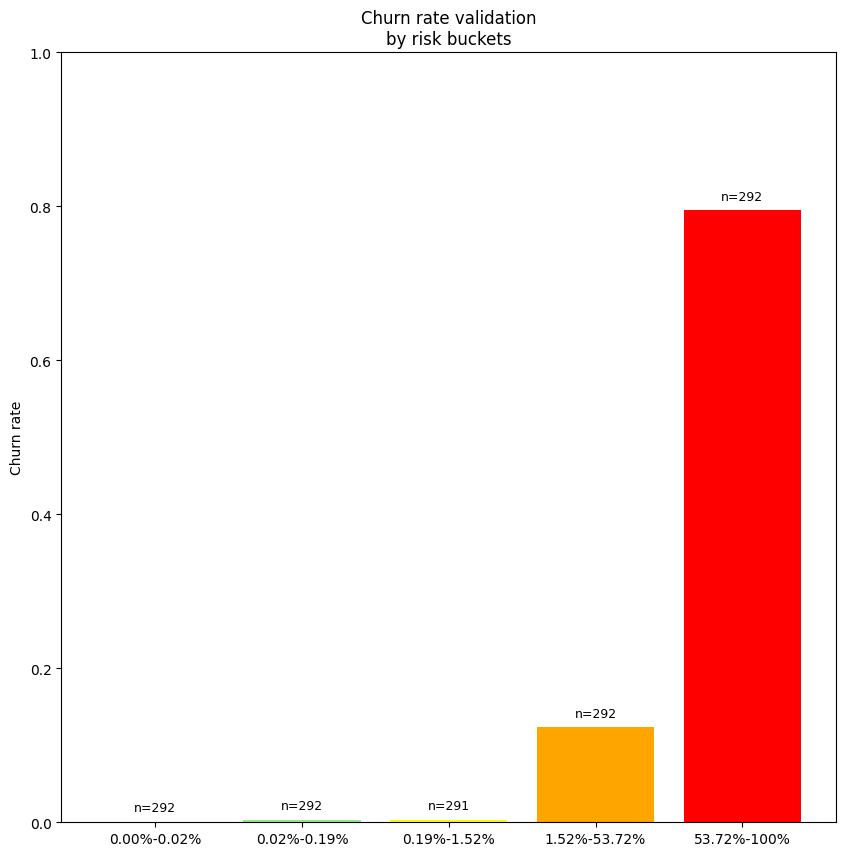

In [30]:

churn_by_risk = results_df.groupby('risk_segment')['actual_churn'].agg(['mean', 'count'])
plt.figure(figsize=(10, 10))
bars = plt.bar(churn_by_risk.index, churn_by_risk['mean'], color=['green', 'lightgreen', 'yellow', 'orange', 'red'])
plt.ylabel('Churn rate')
plt.title('Churn rate validation\nby risk buckets')
plt.xticks()
plt.ylim([0.0, 1])

for i, (bar, count) in enumerate(zip(bars, churn_by_risk['count'])):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'n={count}', ha='center', va='bottom', fontsize=9)



In [41]:
results_df

,degree_id,actual_churn,churn_probability,is_remote,is_bachelor,is_female,active_semesters_first,is_state_funded_mean,age_at_start,is_fall_start,has_gap,is_state_funded_first,financial_status_changed,is_from_budapest,activity_ratio,grade_trajectory,started_strong,started_weak,credits_per_semester,credit_efficiency,cumulative_stability,performance_gap,efficiency_score,weighted_avg,improvement_rate,risk_segment
10344,9216_2MNGINF_Diplomát szerzett_4.0,0,0.0008,0,0,0,4.0000,1.0000,26.5000,1,0,1,0,1,1.0000,1.0900,0,0,30.0000,0.8696,0.8300,-0.2600,3.4609,3.9130,0.2725,0.02%-0.19%
10149,9045_2MNVESZ_Aktív_3.0,0,0.0002,0,0,0,3.0000,1.0000,25.3000,1,0,1,0,0,1.0000,0.2600,0,0,29.0000,0.7500,0.1900,-0.0700,2.3925,3.1820,0.0867,0.02%-0.19%
11855,10558_2BNNKGA_Aktív_5.0,0,0.0004,0,1,1,5.0000,1.0000,18.7000,1,0,1,0,0,1.0000,0.3900,1,0,33.0000,1.0000,0.1300,-0.5200,4.2400,4.6430,0.0780,0.02%-0.19%
169,151_2MNGINF_Aktív_3.0,0,0.0000,0,0,0,3.0000,1.0000,23.9000,1,0,1,0,1,1.0000,0.1100,1,0,30.3333,1.0000,0.0800,-0.0300,3.9700,3.9670,0.0367,0.00%-0.02%
13499,12008_2BNGMEN_Aktív_9.0,0,0.1251,0,1,1,9.0000,1.0000,19.5000,1,0,1,0,1,1.0000,-1.8000,1,0,18.6667,0.6199,1.0100,0.7900,1.7296,2.5400,-0.2000,1.52%-53.72%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12627,11245_7MNNEMZ_Aktív_3.0,0,0.0152,0,0,1,3.0000,1.0000,21.8000,1,0,1,0,1,1.0000,-0.3600,1,0,22.0000,0.7333,0.2200,0.1400,2.6547,3.5880,-0.1200,0.19%-1.52%
8673,7723_3BNKEMN_Aktív_5.0,0,0.0001,0,1,1,5.0000,1.0000,19.6000,0,0,1,0,0,1.0000,1.2000,0,0,29.4000,0.9484,0.6600,-0.5400,3.6892,4.0700,0.2400,0.00%-0.02%
11983,10674_2MNVESZ_Diplomát szerzett_4.0,0,0.0023,0,0,1,4.0000,1.0000,22.9000,1,0,1,0,0,1.0000,0.5300,1,0,31.2500,1.0000,0.2700,-0.2600,4.7400,4.8410,0.1325,0.19%-1.52%
5256,4655_ETNEMBSC_Aktív_3.0,0,0.0001,0,1,1,3.0000,1.0000,19.4000,1,0,1,0,1,1.0000,0.7400,1,0,31.3333,1.0000,0.4800,-0.2600,4.4200,4.4580,0.2467,0.00%-0.02%


Index(['is_remote', 'is_bachelor', 'is_female', 'active_semesters_first', 'is_state_funded_mean', 'age_at_start', 'is_fall_start', 'has_gap', 'is_state_funded_first', 'financial_status_changed', 'is_from_budapest', 'activity_ratio', 'grade_trajectory', 'started_strong', 'started_weak', 'credits_per_semester', 'credit_efficiency', 'cumulative_stability', 'performance_gap', 'efficiency_score', 'weighted_avg', 'improvement_rate'], dtype='object')


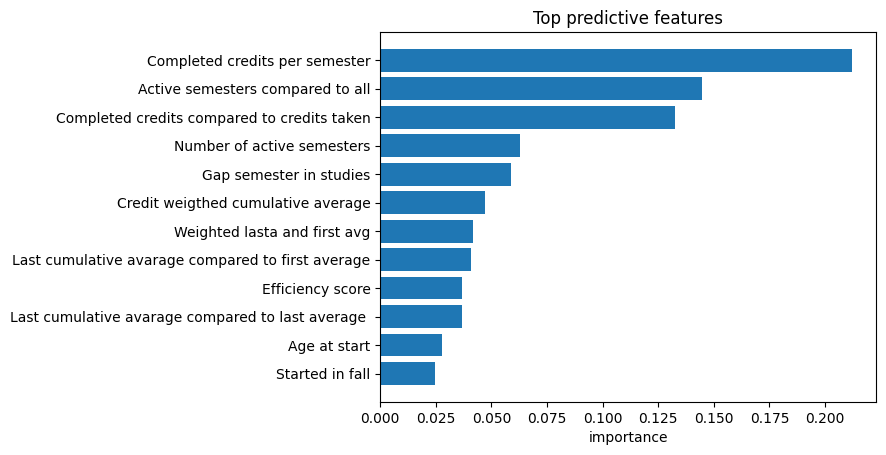

In [31]:
print(X.columns)
feature_name_map = dict(zip(X.columns, ['Part time dedgree', 'Bachelor degree', 'Female student', 'Number of active semesters', 'Number of state funded semester compared to all', 'Age at start', 
 'Started in fall', 'Gap semester in studies', 'Started as state funded', 'Financial status changes', 'From Budapest', 'Active semesters compared to all', 'Grade trajectory', 
 'Good initial results', 'Poor initial results', 'Completed credits per semester', 'Completed credits compared to credits taken', 'Last cumulative avarage compared to first average', 'Last cumulative avarage compared to last average ',
 'Credit weigthed cumulative average', 'Efficiency score', 'Weighted lasta and first avg', 'Improvement rate']))

feature_names = [""]
importances = np.zeros(len(X.columns))
count = 0
for name, estimator in final_model.named_estimators_.items():
    if hasattr(estimator, 'feature_importances_'):
        importances += estimator.feature_importances_
        count += 1
if count > 0:
    avg_importance = importances / count
    feature_importance = pd.DataFrame({'feature': X.columns,'importance': avg_importance}).sort_values('importance', ascending=True).tail(12)
    feature_importance['feature'] = feature_importance['feature'].map(feature_name_map)
    
    plt.barh(range(len(feature_importance)), feature_importance['importance'])
    plt.yticks(range(len(feature_importance)), feature_importance['feature'])
    plt.xlabel('importance')
    plt.title('Top predictive features')


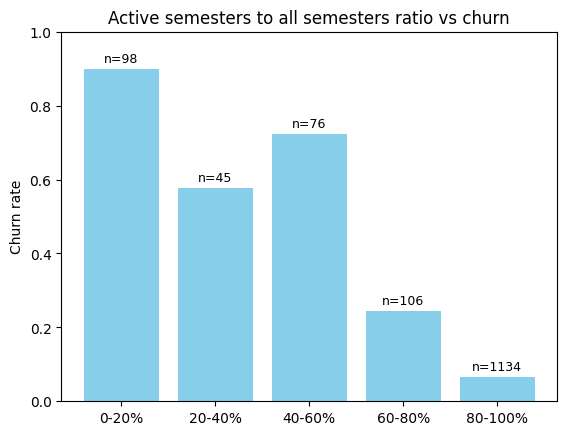

In [46]:
# create 5 equal-width bins from min to max activity_ratio
activity_bins = pd.cut(results_df['activity_ratio'], bins=5, labels=['0-20%', '20-40%', '40-60%', '60-80%','80-100%'])
activity_churn = results_df.groupby(activity_bins)['actual_churn'].agg(['mean', 'count'])
bars = plt.bar(activity_churn.index, activity_churn['mean'], color='skyblue')
plt.ylabel('Churn rate')
plt.title('Active semesters to all semesters ratio vs churn')
plt.ylim([0.0, 1])

for i, (bar, count) in enumerate(zip(bars, activity_churn['count'])):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'n={count}', ha='center', va='bottom', fontsize=9)


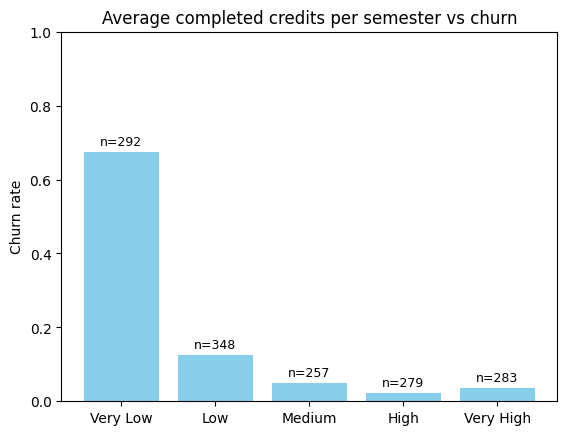

In [45]:
credits_per_semester_bins = pd.qcut(results_df['credits_per_semester'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
credits_per_semester_churn = results_df.groupby(credits_per_semester_bins)['actual_churn'].agg(['mean', 'count'])
bars = plt.bar(credits_per_semester_churn.index, credits_per_semester_churn['mean'], color='skyblue')
plt.ylabel('Churn rate')
plt.title('Average completed credits per semester vs churn')
plt.ylim([0.0, 1])
for i, (bar, count) in enumerate(zip(bars, credits_per_semester_churn['count'])):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'n={count}', ha='center', va='bottom', fontsize=9)

(0.0, 1.0)

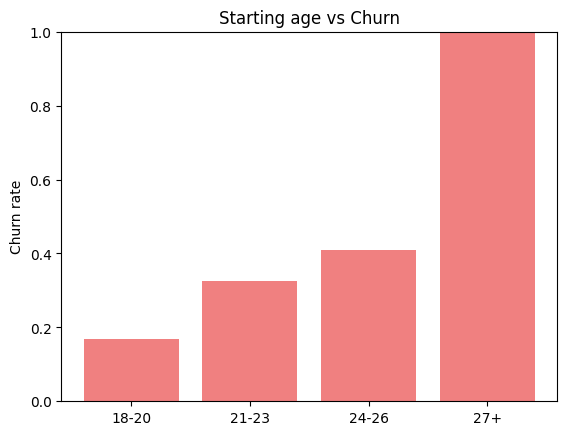

In [47]:

age_bins = pd.cut(results_df['age_at_start'], bins=4, labels=['18-20', '21-23', '24-26', '27+'])
age_churn = results_df.groupby(age_bins)['actual_churn'].mean()
plt.bar(age_churn.index, age_churn.values, color='lightcoral')
plt.ylabel('Churn rate')
plt.title('Starting age vs Churn')
plt.ylim([0.0, 1])




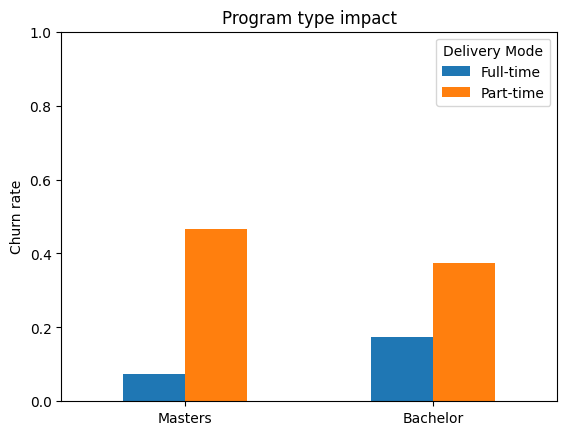

In [35]:
program_analysis = results_df.groupby(['is_bachelor', 'is_remote'])['actual_churn'].mean().unstack()
program_analysis.plot(kind='bar', ax=plt.gca())
plt.ylabel('Churn rate')
plt.xlabel('')
plt.title('Program type impact')
plt.ylim([0.0, 1])

plt.xticks([0, 1], ['Masters', 'Bachelor'], rotation=0)
plt.legend(['Full-time', 'Part-time'], title='Delivery Mode')



(0.0, 1.0)

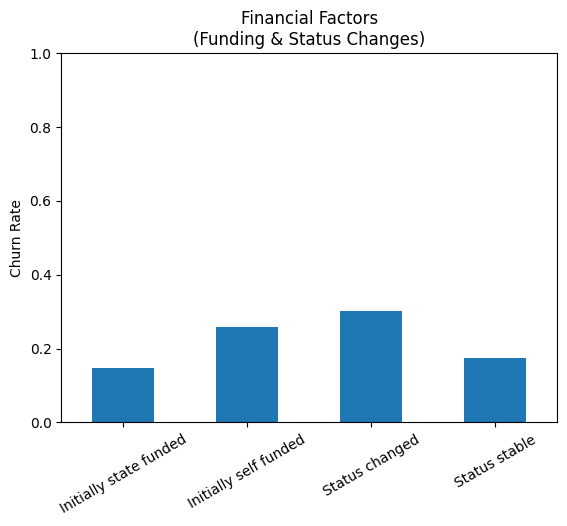

In [40]:
financial_data = results_df[['is_state_funded_first', 'financial_status_changed', 'actual_churn']]
financial_summary = pd.DataFrame({
    'Initially state funded': financial_data[financial_data['is_state_funded_first']==1]['actual_churn'].mean(),
    'Initially self funded': financial_data[financial_data['is_state_funded_first']==0]['actual_churn'].mean(),
    'Status changed': financial_data[financial_data['financial_status_changed']==1]['actual_churn'].mean(),
    'Status stable': financial_data[financial_data['financial_status_changed']==0]['actual_churn'].mean()
}, index=[0])

financial_summary.T.plot(kind='bar', ax=plt.gca(), legend=False)
plt.ylabel('Churn Rate')
plt.title('Financial Factors\n(Funding & Status Changes)')
plt.xticks(rotation=30)
plt.ylim([0.0, 1])


In [38]:
results_df

,degree_id,actual_churn,churn_probability,is_remote,is_bachelor,is_female,active_semesters_first,is_state_funded_mean,age_at_start,is_fall_start,has_gap,is_state_funded_first,financial_status_changed,is_from_budapest,activity_ratio,grade_trajectory,started_strong,started_weak,credits_per_semester,credit_efficiency,cumulative_stability,performance_gap,efficiency_score,weighted_avg,improvement_rate,risk_segment
10344,9216_2MNGINF_Diplomát szerzett_4.0,0,0.0008,0,0,0,4.0000,1.0000,26.5000,1,0,1,0,1,1.0000,1.0900,0,0,30.0000,0.8696,0.8300,-0.2600,3.4609,3.9130,0.2725,0.02%-0.19%
10149,9045_2MNVESZ_Aktív_3.0,0,0.0002,0,0,0,3.0000,1.0000,25.3000,1,0,1,0,0,1.0000,0.2600,0,0,29.0000,0.7500,0.1900,-0.0700,2.3925,3.1820,0.0867,0.02%-0.19%
11855,10558_2BNNKGA_Aktív_5.0,0,0.0004,0,1,1,5.0000,1.0000,18.7000,1,0,1,0,0,1.0000,0.3900,1,0,33.0000,1.0000,0.1300,-0.5200,4.2400,4.6430,0.0780,0.02%-0.19%
169,151_2MNGINF_Aktív_3.0,0,0.0000,0,0,0,3.0000,1.0000,23.9000,1,0,1,0,1,1.0000,0.1100,1,0,30.3333,1.0000,0.0800,-0.0300,3.9700,3.9670,0.0367,0.00%-0.02%
13499,12008_2BNGMEN_Aktív_9.0,0,0.1251,0,1,1,9.0000,1.0000,19.5000,1,0,1,0,1,1.0000,-1.8000,1,0,18.6667,0.6199,1.0100,0.7900,1.7296,2.5400,-0.2000,1.52%-53.72%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12627,11245_7MNNEMZ_Aktív_3.0,0,0.0152,0,0,1,3.0000,1.0000,21.8000,1,0,1,0,1,1.0000,-0.3600,1,0,22.0000,0.7333,0.2200,0.1400,2.6547,3.5880,-0.1200,0.19%-1.52%
8673,7723_3BNKEMN_Aktív_5.0,0,0.0001,0,1,1,5.0000,1.0000,19.6000,0,0,1,0,0,1.0000,1.2000,0,0,29.4000,0.9484,0.6600,-0.5400,3.6892,4.0700,0.2400,0.00%-0.02%
11983,10674_2MNVESZ_Diplomát szerzett_4.0,0,0.0023,0,0,1,4.0000,1.0000,22.9000,1,0,1,0,0,1.0000,0.5300,1,0,31.2500,1.0000,0.2700,-0.2600,4.7400,4.8410,0.1325,0.19%-1.52%
5256,4655_ETNEMBSC_Aktív_3.0,0,0.0001,0,1,1,3.0000,1.0000,19.4000,1,0,1,0,1,1.0000,0.7400,1,0,31.3333,1.0000,0.4800,-0.2600,4.4200,4.4580,0.2467,0.00%-0.02%


In [ ]:
def calculate_roi_potential(avg_tuition_per_year=350000, graduation_years=4):
   total_students = len(results_df)
   
   _, bins = pd.qcut(results_df['churn_probability'], q=5, retbins=True)
   high_threshold = bins[4]  
   
   high_risk_students = len(results_df[results_df['churn_probability'] >= high_threshold])
   
   potentially_saved = high_risk_students * 0.30
   revenue_potential = potentially_saved * avg_tuition_per_year * graduation_years
   
   print(f"Students with >{high_threshold:.1%} churn probability: {high_risk_students}")
   print(f"Conservative intervention success (30%): {potentially_saved:.0f} students")
   print(f"Revenue potential: {revenue_potential:.0f} Ft")

calculate_roi_potential()

Students with >53.7% churn probability: 292
Conservative intervention success (30%): 88 students
Revenue potential: 122640000 Ft
